# k-최근접 이웃 알고리즘을 이용한 투자 전략(knn)

개념은 간단하다.

유한한 특성을 가진 데이터 사이의 거리는 가깝다는 가정에서 출발한다.

책 223페이지의 그림을 보면,

동그라미의 범위를 어떻게 하느냐에 따라서 새로운 데이터가 속하는 범주가 다르다.

knn 방법을 하기 위해서는 데이터를 대량 확보 해야 한다.

이는 매우 직관적이고 간단한 알고리즘이며 비교적 일관적인 결과를 도출하기에 현업에서도 많이 쓰인다.

knn을 통해 spy지수(앞서 보았던 etf s&p 500 데이터)를 예측하는 모델을 설계하고, 정확도를 높임으로서 더 쉽게 투자 할 수 있도록 하자.

(참고한 책:'퀀트 전략을 위한 인공지능 트레이딩')


# 1. 관련 라이브러리 다운로드

- 먼저 야후파이낸스를 다운로드받자. 야후파이낸스는  pandas 데이터프레임을 사용하며, 재무재표,주주정보 등 수집하기 어려운 다양한 데이터를 수집할 수 있다.

- 그런 다음 pandas-datareader를 다운받는다. 주식 뿐만 아니라 여러 통계 데이터들을 가져올 수 있는 api 모듈이다.

In [1]:
pip install yfinance --upgrade

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install pandas-datareader

#설치가 되어 있지 않다면, 설치를 해야 한다.

# 2.데이터 불러오기

사이킷런을 사용하였다. 사이킷런은 파이썬에서 머신러닝 및 데이터분석을 위한 강력한 오픈 라이브러리이다. 이 라이브러리는 다양한 머신러닝 알고리즘, 데이터 전처리 도구, 모델 평가 도구 등을 제공하여 사용자가 머신러닝 프로젝트를 구축하고 평가하는 데 도움을 준다.

사이킷런은 사용하기 쉬우며, 데이터 과학자와 엔지니어가 효율적으로 모델을 개발하고 최적화하는데 도움이 된다.

분류,회귀,군집화,차원 축소 등 다양한 머신러닝 작업을 지원한다.

In [40]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from pandas_datareader import data as pdr #Yahoo Finance으로부터 데이터를 불러오기 위한 패키지


In [41]:
#yfinance를 이용해서 데이터를 불러오자.

import yfinance as yf

#symbol, start date, end date를 지정한다.
#만약 다른 데이터를 불러오고 싶다면, spy 대신 gld(금)나 tlt(미국 국채 20)등 다른 티커명을 입력하자.

#start_date나 end_date를 조작해서 다양한 기간에 따른 결과를 얻어보자.
symbol = 'SPY'
start_date = '2012-01-01'
end_date = '2017-01-01'


df = yf.download(symbol,start=start_date,end=end_date)


#데이터 불러오기

print(df)

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-01-03  127.760002  128.380005  127.430000  127.500000  102.458984   
2012-01-04  127.199997  127.809998  126.709999  127.699997  102.619705   
2012-01-05  127.010002  128.229996  126.430000  128.039993  102.892906   
2012-01-06  128.199997  128.220001  127.290001  127.709999  102.627724   
2012-01-09  128.000000  128.179993  127.410004  128.020004  102.876816   
...                ...         ...         ...         ...         ...   
2016-12-23  225.429993  225.720001  225.210007  225.710007  201.048355   
2016-12-27  226.020004  226.729996  226.000000  226.270004  201.547150   
2016-12-28  226.570007  226.589996  224.270004  224.399994  199.881500   
2016-12-29  224.479996  224.889999  223.839996  224.350006  199.836914   
2016-12-30  224.729996  224.830002  222.729

In [42]:
#na 데이터를 지우고, 데이터를 확인한다.

df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000,102.458984,193697900
2012-01-04,127.199997,127.809998,126.709999,127.699997,102.619705,127186500
2012-01-05,127.010002,128.229996,126.430000,128.039993,102.892906,173895000
2012-01-06,128.199997,128.220001,127.290001,127.709999,102.627724,148050000
2012-01-09,128.000000,128.179993,127.410004,128.020004,102.876816,99530200


# 2.피처 데이터 및 레이블 데이터 생성

밑에서, 레이블 데이터를 생성할 때 2개의 데이터를 생성한다. 

하나는 '다음날의 종가가 다음날의 시가보다 높다면 오른다고 정의'할 것이고,

다른 하나는 '어제의 종가가 어제의 시가보다 높다면 오른다고 정의'할 것이다.

In [43]:
#필요한 데이터만 골라 다른 배열에 저장한다.
#이름을 df1으로 저장한다.
df1 = df[['Open','High','Low','Close']].copy()
df1.head()

,Open,High,Low,Close
Date,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000
2012-01-04,127.199997,127.809998,126.709999,127.699997
2012-01-05,127.010002,128.229996,126.430000,128.039993
2012-01-06,128.199997,128.220001,127.290001,127.709999
2012-01-09,128.000000,128.179993,127.410004,128.020004


In [45]:
#시가와 종가의 차이/ 최고가와 최저가의 차이를 구한다.

df1['gap-OpenClose'] = df1['Open'] - df1['Close']
df1['gap-HighLow'] = df1['High'] - df1['Low']
df1 = df1.dropna() #중간중간에 결측치를 제거한다.

#X,Y를 정의한다. X에는 시가와 종가의 차이, 고가와 저가의 차이를 저장하고,
#Y는 주가의 오름과 내림을 정의한다. 다음날의 종가가 다음날의 시가보다 크다면1, 아니면 -1이다.
#시가, 종가를 평가할 때, shift를 통해 행을 올린다.
X = df1[['gap-OpenClose','gap-HighLow']]
Y = np.where(df1['Close'].shift(-1) > df1['Open'].shift(-1), 1, -1)


#다음날의 종가가 다음날의 시가보다 높다면 오른다고 치자.

In [46]:
X.head()

,gap-OpenClose,gap-HighLow
Date,,
2012-01-03,0.260002,0.950005
2012-01-04,-0.500000,1.099998
2012-01-05,-1.029991,1.799995
2012-01-06,0.489998,0.930000
2012-01-09,-0.020004,0.769989


# 3. 데이터 분리, 모델 학습

## 학습데이터, 테스트 데이터 분리

In [49]:
split_ratio = 0.8
split = int(split_ratio*len(df1))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

In [63]:
#knn 학습

#for 반복문을 통해 1~15까지의 k값을 가진 모델을 만들어본다.
#학습을 하는데 KNeighborsClassifier을 가져온다.
#중요 개념: n_neighbors는 학습을 시킬 때 인접한 샘플의 수이다.즉, 이 숫자가 높을 수록 인접한 샘플의 수가 늘어난다. 
#train데이터와 test데이터의 배열을 정의한다.
train_acc=[]
test_acc=[]

for i in range(1,15):
    clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=i) #이 함수를 통해 모델을 훈련시킨다.
    clf.fit(X_train, Y_train)
    prediction = clf.predict(X_test)
    train_acc.append(clf.score(X_train, Y_train)) #각각의 정확도들을 train_acc에 추가한다.
    test_acc.append((prediction==Y_test).mean())


# 4.결과를 그래프로 만들어주기

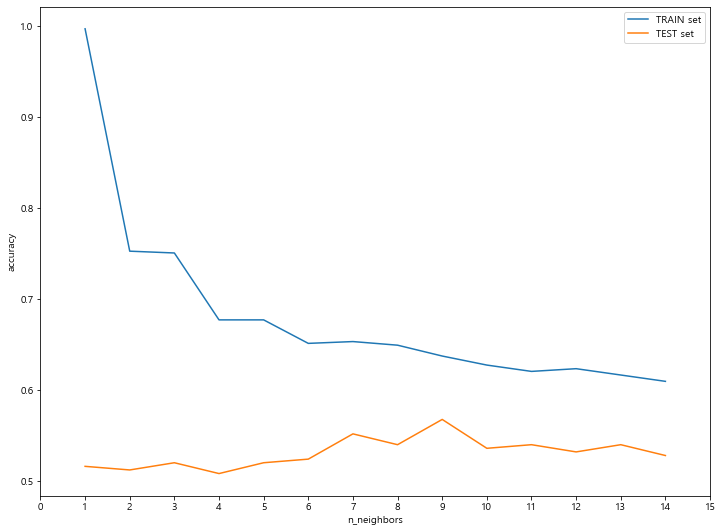

In [53]:
plt.figure(figsize=(12,9))
plt.plot(range(1,15),train_acc,label='TRAIN set') #train set에 대한 선을 긋는다.
plt.plot(range(1,15),test_acc,label='TEST set') #test set에 대한 선을 긋는다.
plt.xlabel("n_neighbors") #x축에 제목을 붙인다.
plt.ylabel("accuracy") #y축에 제목을 붙인다.
plt.xticks(np.arange(0,16,step=1))
plt.legend()

# 5. 결과 산출

In [52]:
#머신러닝에서 얻고자 하는 것은 test set의 성능이 좋은 것이기 때문에, 9를 선택한다

In [57]:
knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train,Y_train) #9로 설정하고 학습을 시킨다.


#수치에 약간의 변형을 가해서 가독성을 높인다.(100을 곱하고 %을 추가.)
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))*100 
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))*100 

print('훈련 정확도 : %.2f' % accuracy_train + '%') 
print('테스트 정확도 : %.2f' % accuracy_test + '%')

훈련 정확도 : 63.72%
테스트 정확도 : 56.75%


   # 결과: test set의 성능이 가장 좋은 9번으로 예측을 한 결과, 테스트 정확도는 56.7프로가 나왔다. 그렇다면, for loop문을 이용해서 1번~15번에서의 test set의 정확도를 산출해보자. 그리고, 그래프를 그려보자.

# 6.다른 경우에서의 결과 산출

In [58]:
#위의 설명에서와 같이, 9를 대입하지 않고,1부터 15까지 다 대입을 하면서 정확도의 차이를 알아보고, 이를 토대로 그래프를 그려보자.

In [60]:
#정확도를 저장하는 리스트를 만들자.

accuracy_test_list =[]

for n in range(1,15):
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train,Y_train) #9로 설정하고 학습을 시킨다.
        #수치에 약간의 변형을 가해서 가독성을 높인다.(100을 곱하고 %을 추가.)
        accuracy_train = accuracy_score(Y_train, knn.predict(X_train))*100 
        accuracy_test = accuracy_score(Y_test, knn.predict(X_test))*100 

        print('훈련 정확도 : %.2f' % accuracy_train) 
        print('테스트 정확도 : %.2f' % accuracy_test)
        accuracy_test_list.append(accuracy_test)
        

훈련 정확도 : 99.70
테스트 정확도 : 51.59
훈련 정확도 : 75.25
테스트 정확도 : 51.19
훈련 정확도 : 75.05
테스트 정확도 : 51.98
훈련 정확도 : 67.69
테스트 정확도 : 50.79
훈련 정확도 : 67.69
테스트 정확도 : 51.98
훈련 정확도 : 65.11
테스트 정확도 : 52.38
훈련 정확도 : 65.31
테스트 정확도 : 55.16
훈련 정확도 : 64.91
테스트 정확도 : 53.97
훈련 정확도 : 63.72
테스트 정확도 : 56.75
훈련 정확도 : 62.72
테스트 정확도 : 53.57
훈련 정확도 : 62.03
테스트 정확도 : 53.97
훈련 정확도 : 62.33
테스트 정확도 : 53.17
훈련 정확도 : 61.63
테스트 정확도 : 53.97
훈련 정확도 : 60.93
테스트 정확도 : 52.78


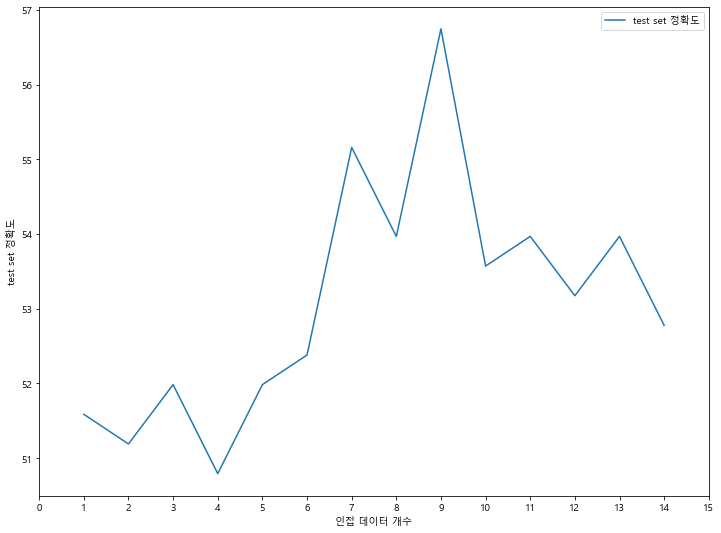

In [64]:
plt.figure(figsize=(12,9))
plt.plot(range(1,15),accuracy_test_list,label='test set 정확도') 
plt.xlabel('인접 데이터 개수') #x축에 제목을 붙인다.
plt.ylabel("test set 정확도") #y축에 제목을 붙인다.
plt.xticks(np.arange(0,16,step=1))
plt.legend()

# 7. 인사이트 산출


- 1.knn을 통해 주가 데이터를 분석할 경우, 인접 데이터 개수를 적당히 많이 추가하는 것이 좋다. 인접 데이터가 너무 많아도 정확하지 않고, 너무 적어도 정확하지 않다.

- 2.인접 데이터 개수를 최적화했다고 하더라도, 절대적인 정확도를 높일 수는 없다. 그러므로, knn은 '메인 도구'가 아닌 '도구 중의 하나'로 이용해야 할 것이다.

- 3.정확도를 높이기 위해서는 test_set 데이터의 비율을 높이거나, 인접 데이터 개수의 범위를 조절하거나 해야 할 것이다. 이는 2번 파일에서 논할 것이다. (정확도를 높인다면, knn을 퀀트 투자에 활용할 수 있을 것이다.)

- 4.절대 모멘텀과의 상관관계: 절대 모멘텀은 1달, 1년 간격이여서 기간 단위가 다르지만, 논리는 비슷하기 때문에 괜찮다. 2번 파일에서 절대 모멘텀에서 했던 것과 같이 기간 단위를 1달, 1년 간격으로 만든 다음 정확도를 높이는 과정을 거치도록 하자.